In [6]:
#!pip install fastbook
from fastbook import *
from fastai.vision.all import *
import numpy as np
import PIL
from os import *
from fastai import *
from fastai.tabular import *
from fastai.vision import *
import fastai.vision as vision
#from fastai.vision.widgets import *
#from utils import *

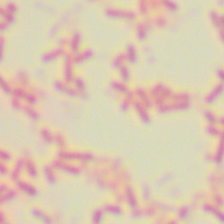

In [7]:
#quick test to see an image
pictu = "../input/smalldibas/cropped/Pseudomonas.aeruginosa/img7094.png"
dest = Path(pictu)
im = Image.open(dest)
im.to_thumb(2048,1532)

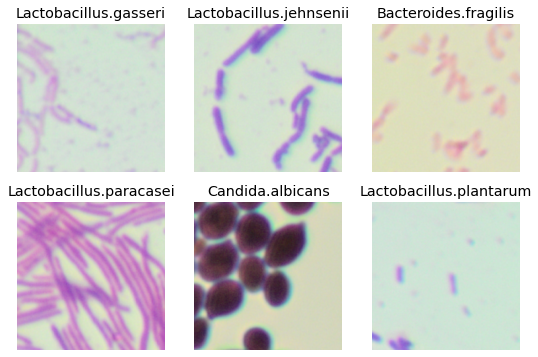

In [8]:
path = r"../input/smalldibas/cropped"

#creating data block
dls = DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
).dataloaders(path)

dls.show_batch(max_n=6)

In [ ]:
##loading my pretrained pth didnt work bc apparently it cant find the file on kaggle?
#Altlearn = vision_learner(dls, resnet50, metrics=error_rate)
#Altlearn.load(Path("../input/badbacteriamodel/OriginalModel"))

In [9]:
learn = vision_learner(dls, resnet50, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.430746,0.231753,0.075221,04:56


epoch,train_loss,valid_loss,error_rate,time
0,0.223123,0.161697,0.052683,03:43
1,0.120530,0.085677,0.025719,03:44
2,0.040984,0.049965,0.015902,03:24
3,0.010516,0.042931,0.011892,03:28


SuggestedLRs(valley=1.3182567499825382e-06)

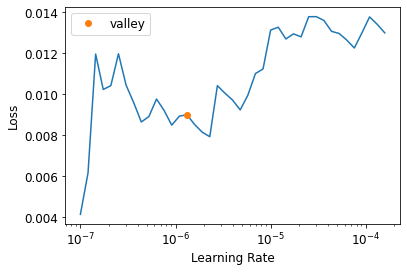

In [11]:
learn.lr_find()

In [13]:
##cleaning bad images (bc my imput will definetely be of the same quality)
##didnt work due to presumably package issues
#cleaner = ImageClassifierCleaner(learn)
#cleaner

epoch,train_loss,valid_loss,error_rate,time
0,0.009367,0.040681,0.011892,03:42
1,0.006711,0.040758,0.012168,03:22
2,0.008467,0.041268,0.011062,03:21
3,0.006472,0.040414,0.011753,03:21
4,0.006806,0.039999,0.011338,03:22
5,0.006388,0.039723,0.011200,03:22
6,0.005370,0.041273,0.011062,03:22
7,0.005601,0.039388,0.010785,03:22
8,0.004361,0.039419,0.011477,03:22
9,0.005108,0.039242,0.010924,03:23


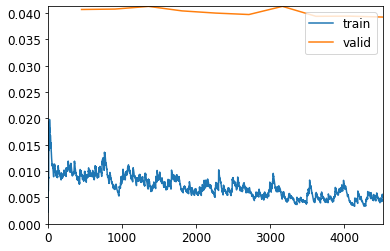

In [14]:
#retraining w different learning rate at the loss valley
learn.fit_one_cycle(10, 2e-06, cbs=[ShowGraphCallback()])

looks like the model is slightly overfitting and the refinement epochs didnt do too much to help. However, its such a small difference that it should be fine. We can investigate this more as we evaluate the model here:

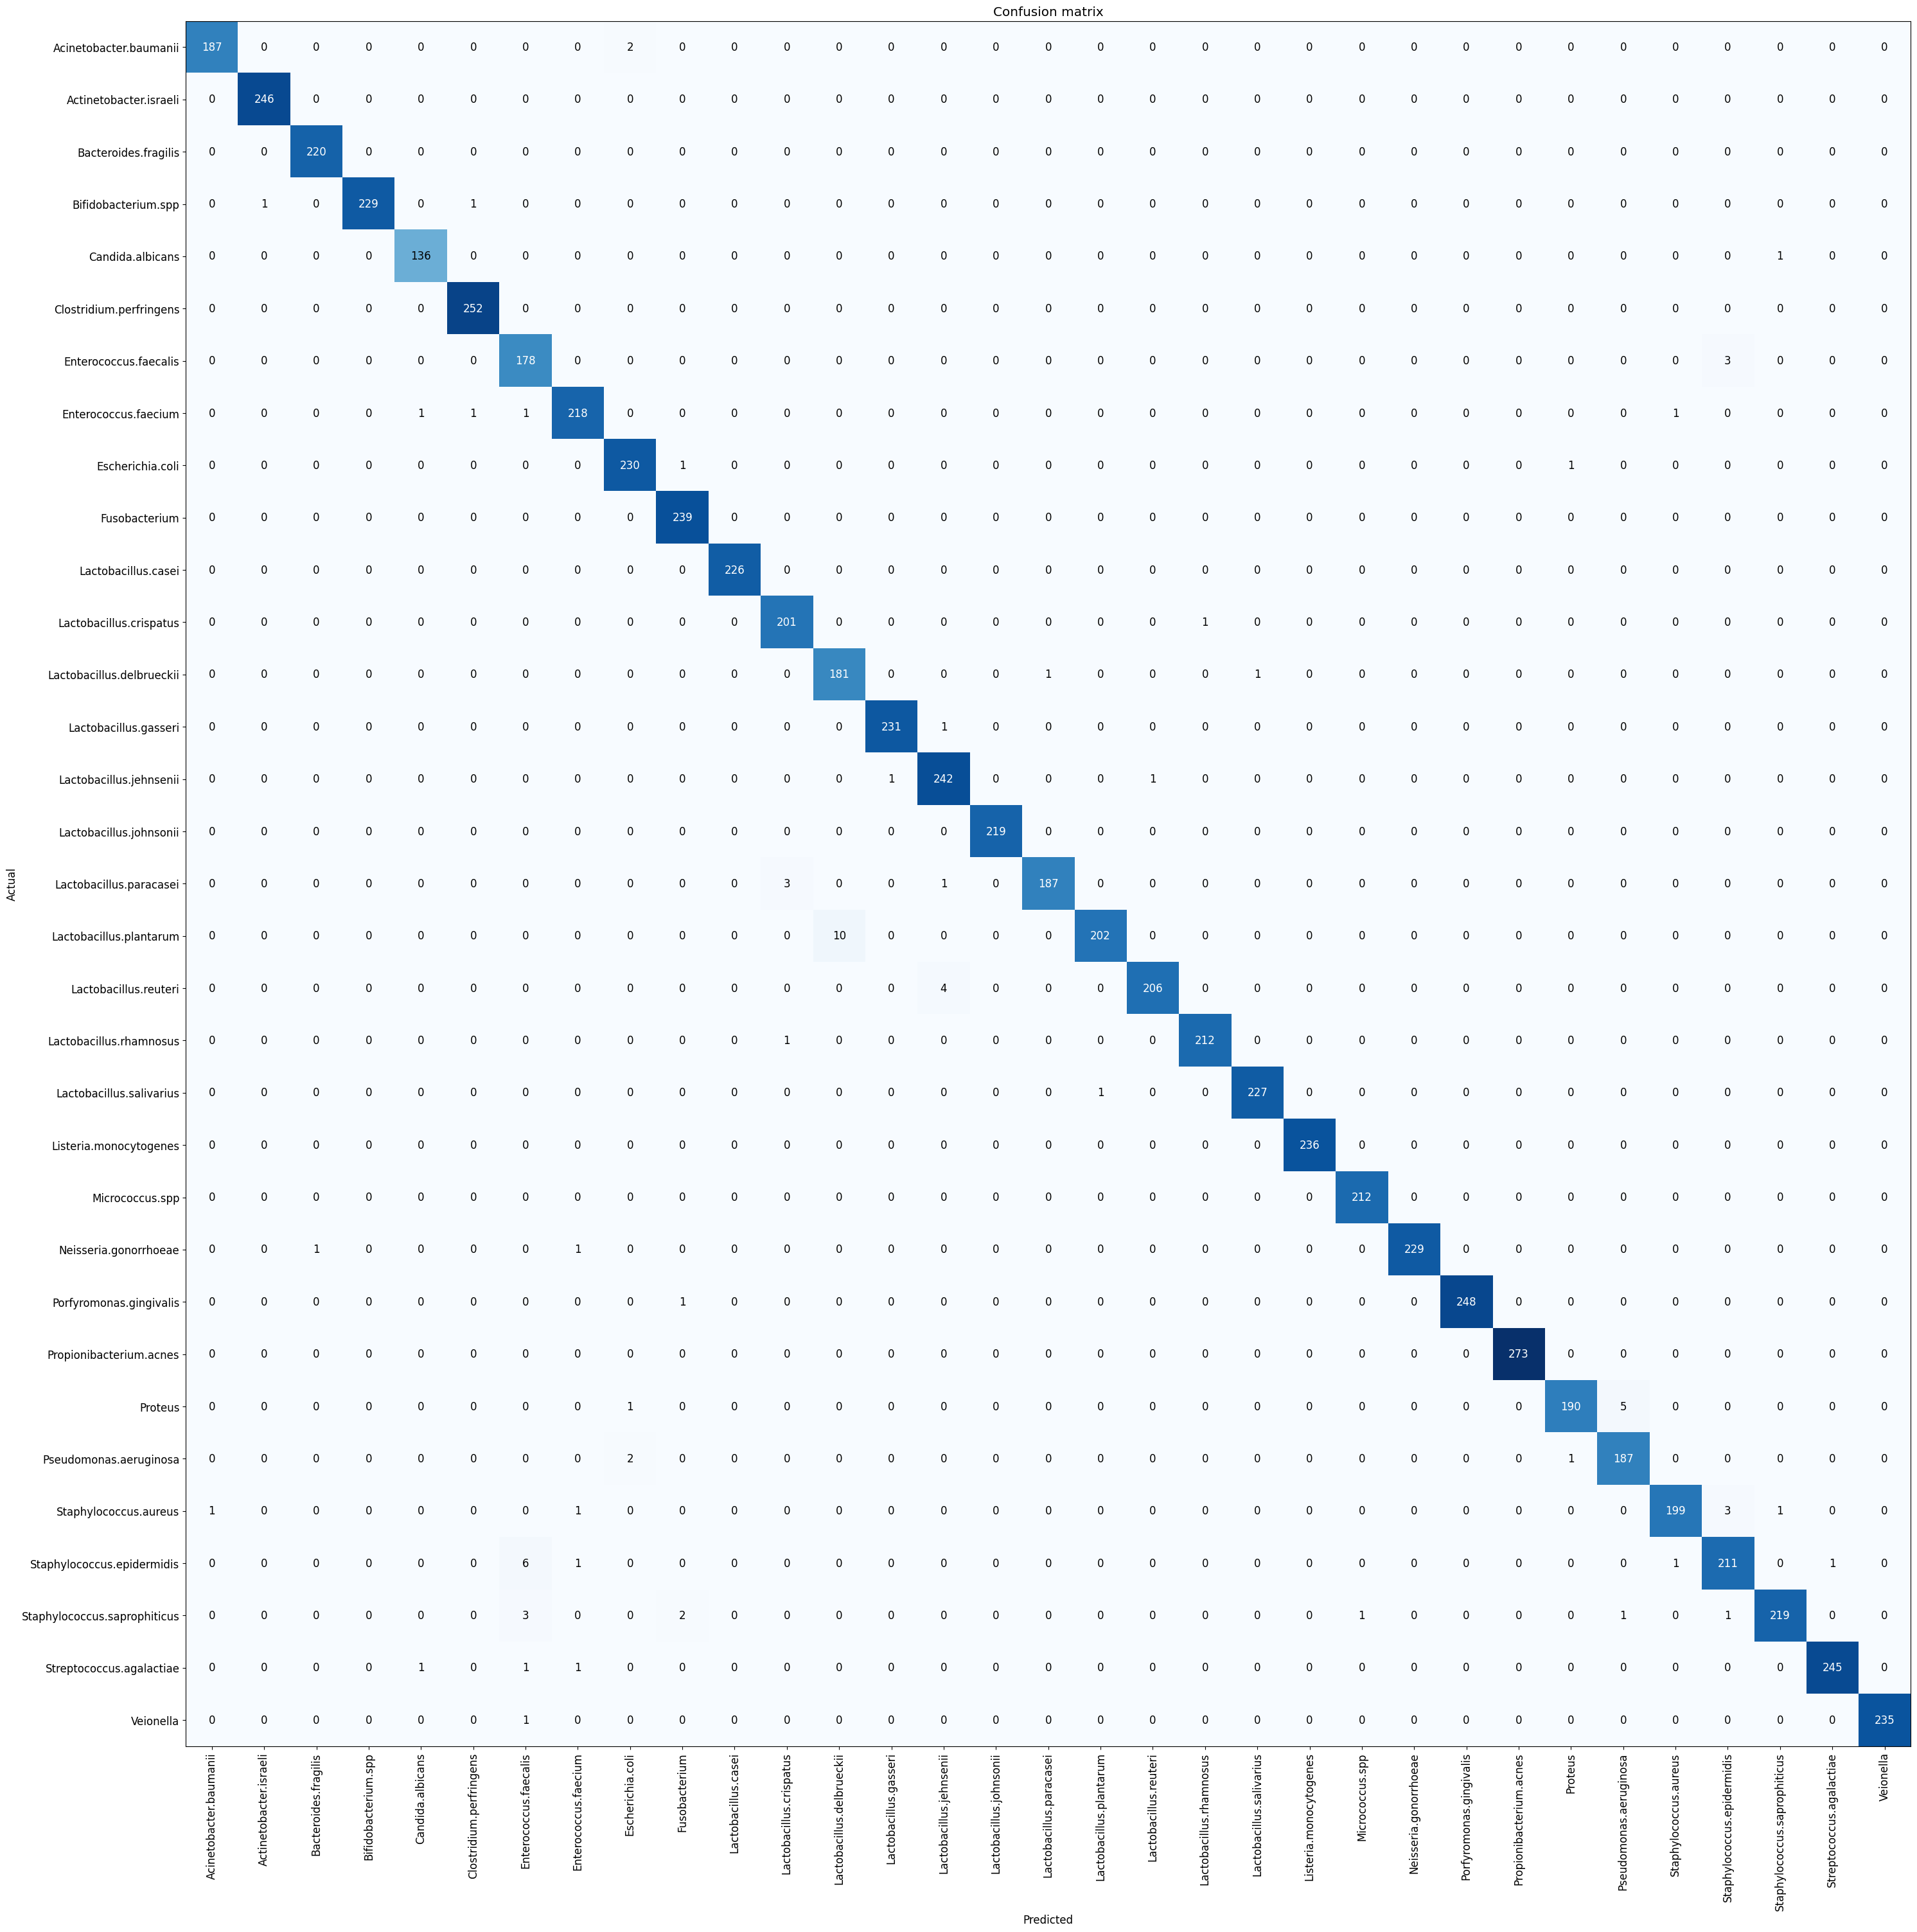

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(30,30), dpi=100)

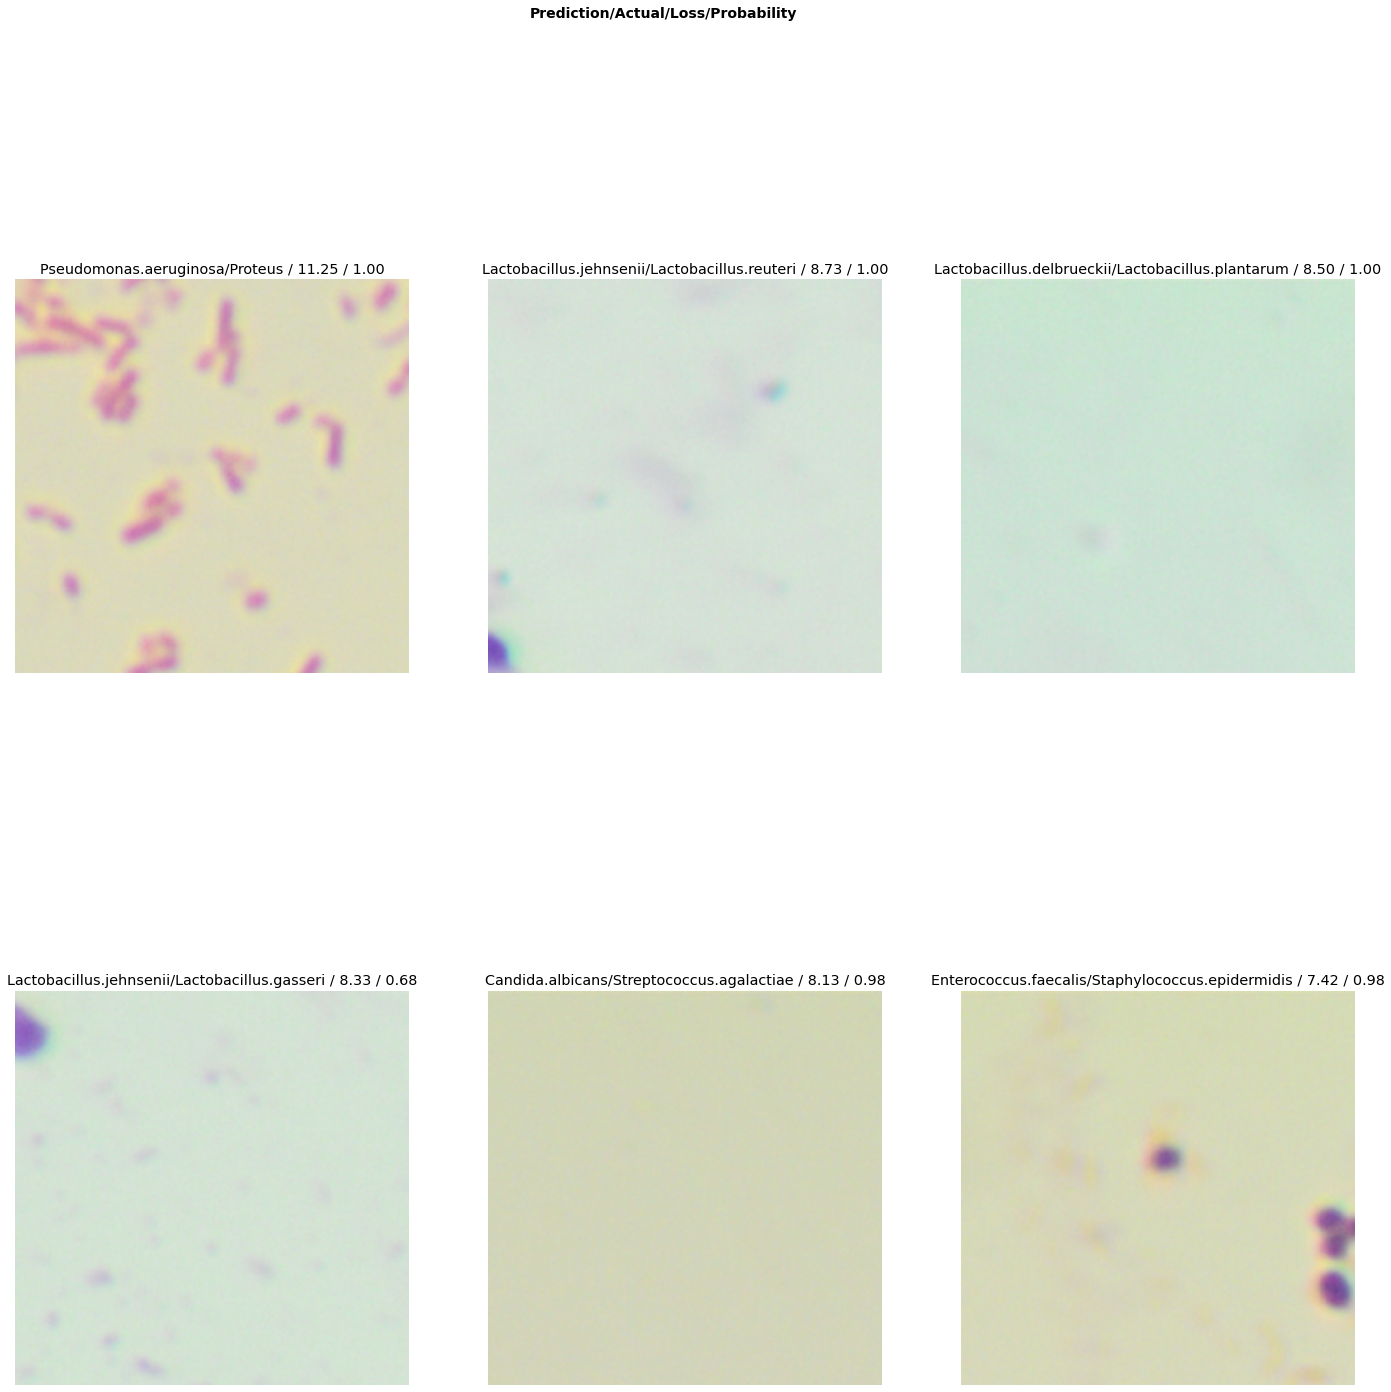

In [16]:
#plotting the images the model had the most trouble with
interp.plot_top_losses(6, figsize=(24,24))

It can be seen here the model seems to do surprisingly well, and the images it struggles on are either almost blank or the strains are extremely similar phenotypically. 

In [20]:
#!pip install fastai2
from fastai2.vision.widgets import *
cleaner = ImageClassifierCleaner(learn)
cleaner

#RuntimeError: tensor.H is only supported on matrices (2-D tensors). Got 1-D tensor.

ModuleNotFoundError: No module named 'fastai2'

In [22]:
#functions for trying out the initial model on my images(ignore)
def identifyBacteria(impath):
    is_bacteria,_,probs = learn.predict(PILImage.create(impath))
    print(f"This is a: {is_bacteria}.")
    print(f"Probability: {maximum(probs)}")

In [21]:
testing = "../input/smalldibas/cropped/Lactobacillus.rhamnosus/img15286.png"
learn.predict(PILImage.create(testing))

('Lactobacillus.rhamnosus',
 TensorBase(19),
 TensorBase([1.9593e-08, 6.2731e-08, 7.3907e-09, 2.9837e-08, 3.1281e-09, 4.3568e-08, 4.1959e-09, 4.4326e-08, 3.9232e-08, 5.9301e-07, 2.4163e-09, 1.0051e-06, 1.0921e-08, 1.5125e-05, 1.8590e-07, 6.0348e-07,
         1.7772e-05, 3.4312e-07, 6.0930e-07, 9.9996e-01, 8.2426e-11, 3.2116e-09, 3.4022e-08, 1.0314e-08, 9.4984e-07, 2.5658e-09, 8.0426e-07, 1.5344e-07, 8.6923e-08, 3.3632e-08, 5.1917e-09, 1.1836e-08,
         1.1010e-07]))

In [19]:
#exporting
learn.export('Bacteria-Classifier')